In [1]:
import time
import os
import urllib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno

from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

In [2]:
data_url = 'https://raw.githubusercontent.com/mo-amininasab/california_housing_AD/master/housing.csv'
data = pd.read_csv(data_url)

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Take a Quick Look at the Data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [17]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Dealing with missing data

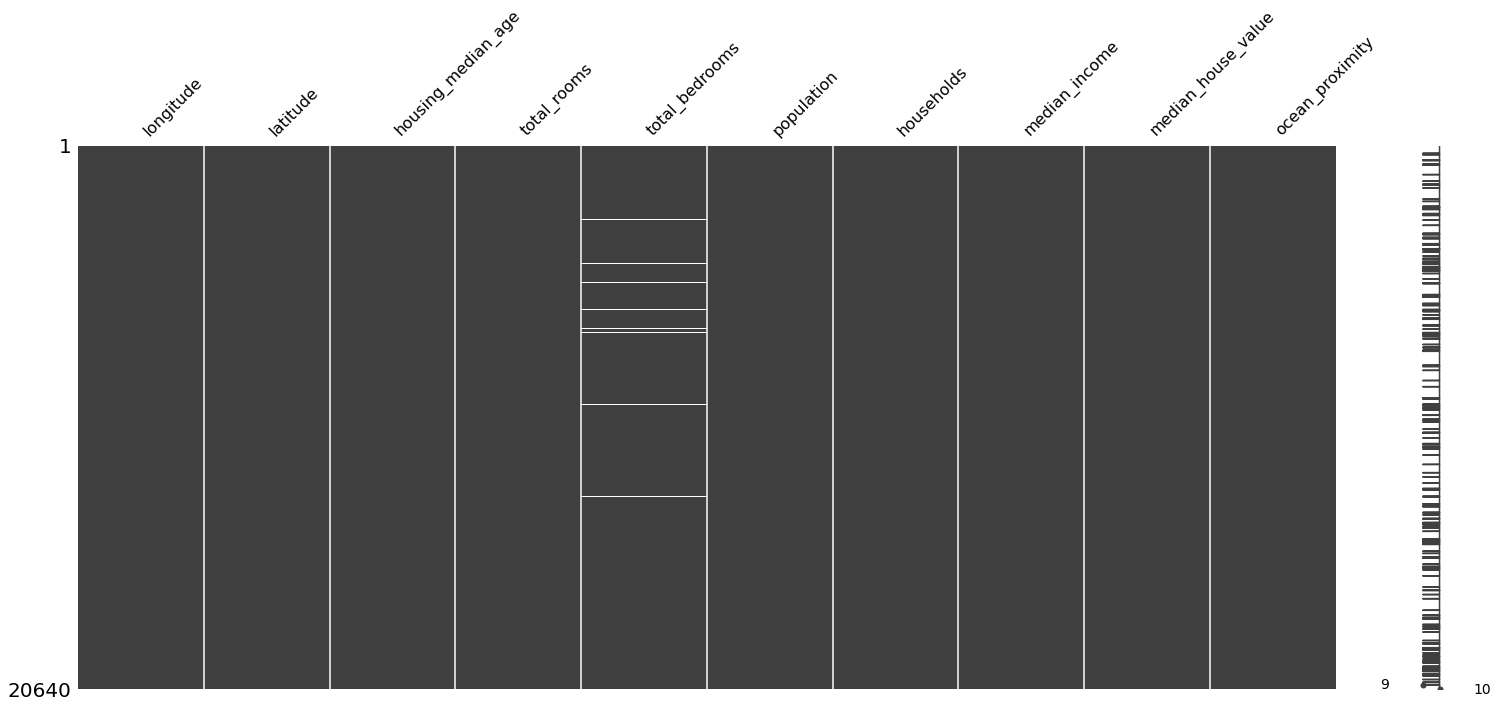

In [7]:
missingno.matrix(data)

In [8]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
data.isna().sum().sum() / data.shape[0]

0.01002906976744186

We can ignore 1% of the data.

In [10]:
data.dropna(subset=['total_bedrooms'], inplace=True)

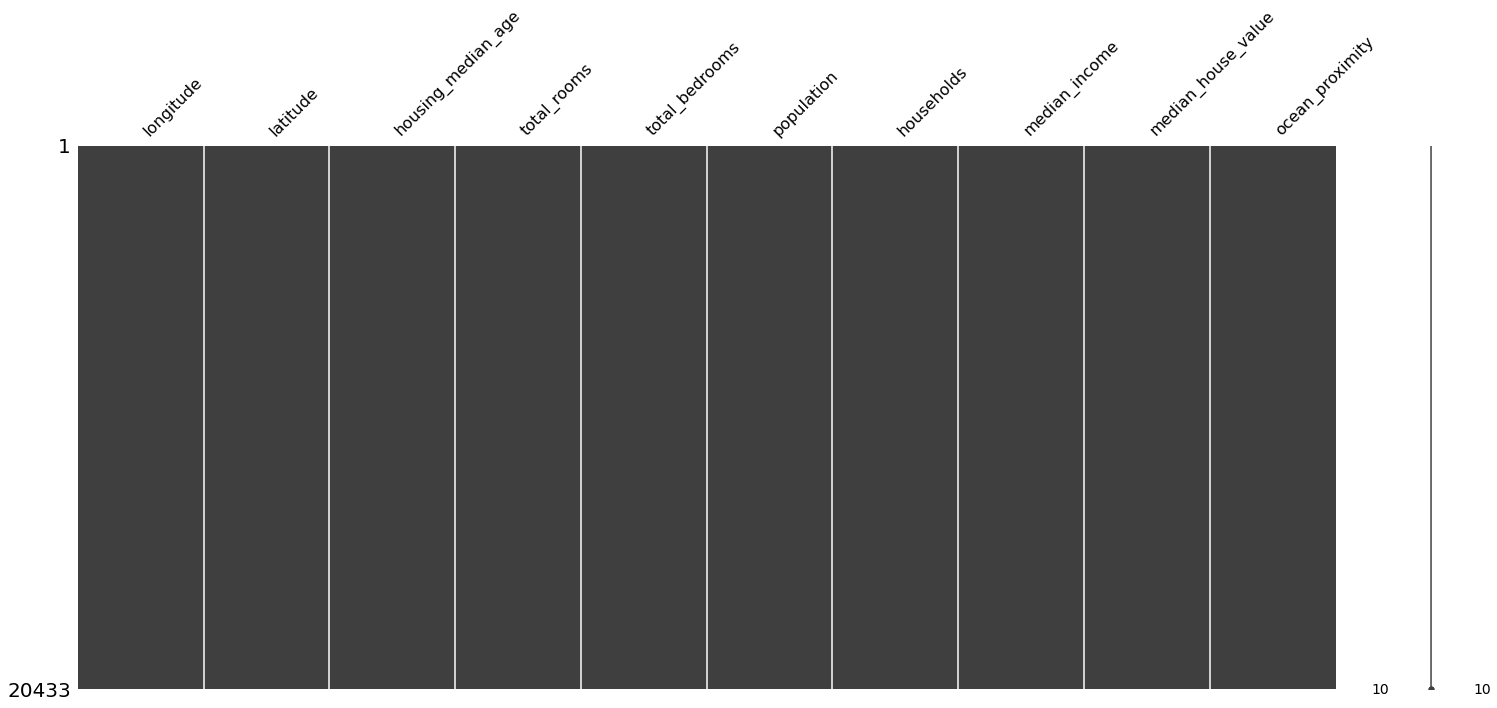

In [11]:
missingno.matrix(data)

## Visualizing the Data to Gain Insights

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5928bf0190>,
      dtype=object)

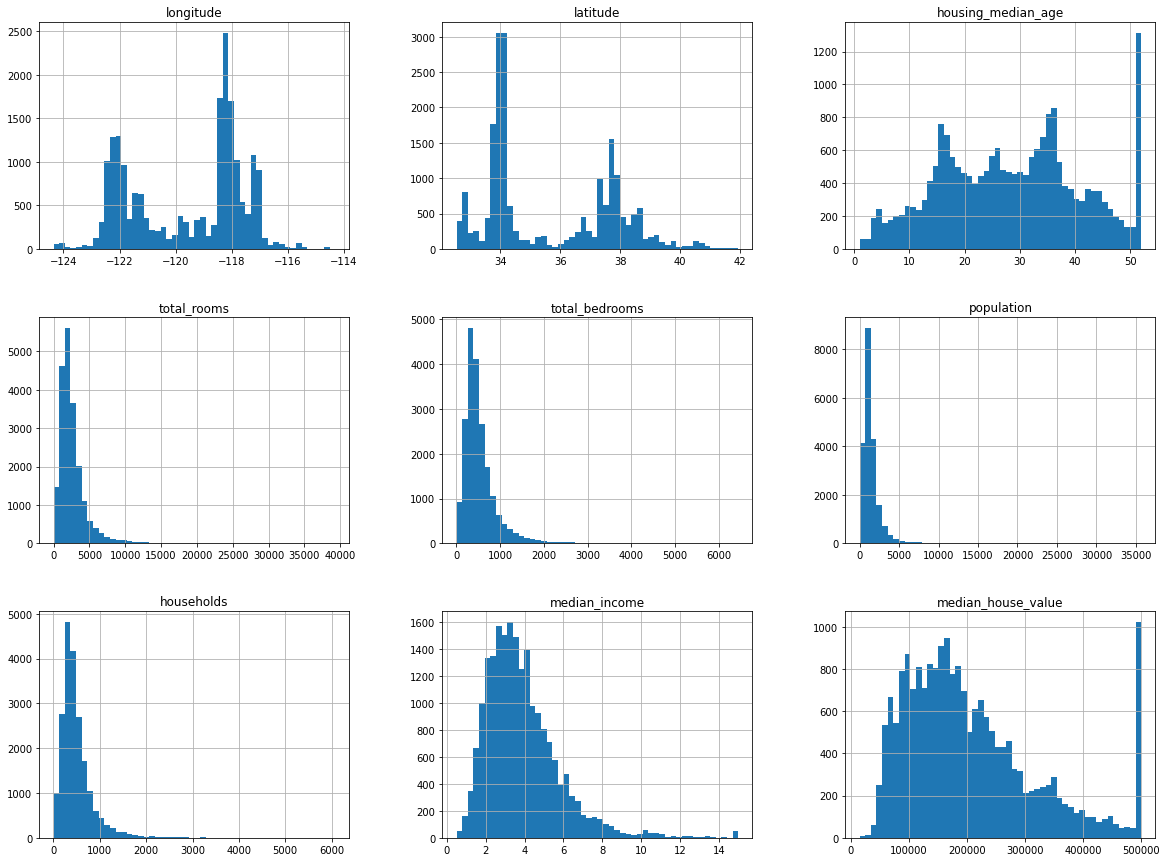

In [12]:
data.hist(bins=50, figsize=(20, 15))

### Visualizing Geographical Data

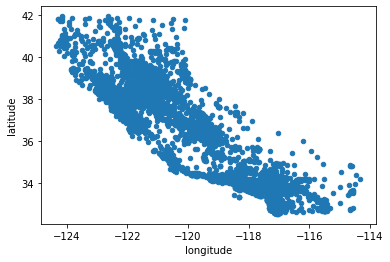

In [13]:
data.plot(kind='scatter', x='longitude', y='latitude')

In [14]:
# Download the California image
images_path = os.path.join('.', "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f5927d94590>)

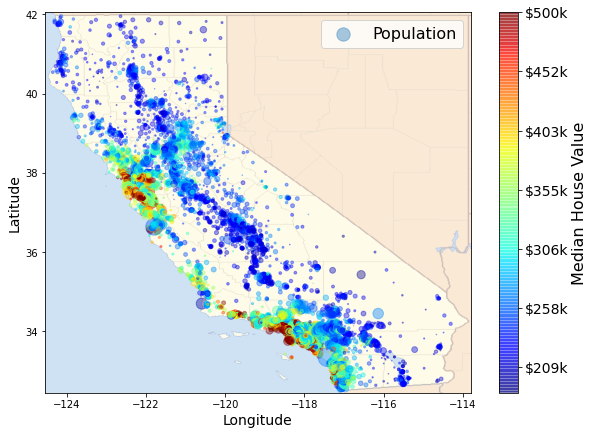

In [60]:
import matplotlib.image as mpimg

california_img = mpimg.imread(os.path.join(images_path, filename))
ax = data.plot(kind="scatter",
                  x="longitude",
                  y="latitude",
                  figsize=(10, 7),
                  s=data['population'] / 100,
                  label="Population",
                  c="median_house_value",
                  cmap=plt.get_cmap("jet"),
                  colorbar=False,
                  alpha=0.4)
plt.imshow(california_img,
           extent=[-124.55, -113.80, 32.45, 42.05],
           alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = data["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values / prices.max())
cbar.ax.set_yticklabels(["$%dk" % (round(v / 1000)) for v in tick_values],
                        fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Preparing the data for model

In [19]:
num_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
cat_features= ['ocean_proximity']
# cols = categorical_cols + numerical_cols

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            # ('attribs_adder', CombinedAttributesAdder()),
                            ('std_scaler', StandardScaler())])

cat_transformer = Pipeline(
    [
        # ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder())
    ],
)

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
],
                                 remainder='drop',
                                 n_jobs=-1)

In [20]:
data_prepared = preprocessor.fit_transform(data)

In [30]:
pd.DataFrame(data_prepared).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.327314,1.051717,0.982163,-0.803813,-0.970325,-0.973320,-0.976833,2.345163,2.128819,0.0,0.0,0.0,1.0,0.0
1,-1.322323,1.042355,-0.606210,2.042130,1.348276,0.861339,1.670373,2.332632,1.313626,0.0,0.0,0.0,1.0,0.0
2,-1.332305,1.037674,1.855769,-0.535189,-0.825561,-0.819769,-0.843427,1.782939,1.258183,0.0,0.0,0.0,1.0,0.0
3,-1.337296,1.037674,1.855769,-0.623510,-0.718768,-0.765056,-0.733562,0.932970,1.164622,0.0,0.0,0.0,1.0,0.0
4,-1.337296,1.037674,1.855769,-0.461970,-0.611974,-0.758879,-0.628930,-0.013143,1.172418,0.0,0.0,0.0,1.0,0.0


## Train models

In [72]:
t1 = time.time()
outlier_detection = DBSCAN(eps=1,
                           metric='euclidean',
                           min_samples=5,
                           n_jobs=-1)
clusters = outlier_detection.fit_predict(data_prepared)
t2 = time.time()

In [101]:
print((t2-t1)/60)

0.10723797877629598


In [74]:
for i in range(len(clusters)):
  if clusters[i] != -1:
    clusters[i] = 0

In [75]:
np.unique(clusters, return_counts=True)

(array([-1,  0]), array([  998, 19435]))

In [100]:
data.iloc[np.argwhere(clusters == -1).flatten()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY
61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY
95,-122.26,37.80,36.0,5329.0,2477.0,3469.0,2323.0,2.0096,130000.0,NEAR BAY
104,-122.26,37.81,34.0,5871.0,1914.0,2689.0,1789.0,2.8406,335700.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20530,-121.76,38.57,11.0,15018.0,3008.0,7984.0,2962.0,3.1371,201800.0,INLAND
20543,-121.74,38.55,33.0,6861.0,1820.0,3717.0,1767.0,1.7311,182600.0,INLAND
20544,-121.76,38.55,23.0,8800.0,1857.0,6330.0,1832.0,2.0650,219400.0,INLAND
20563,-121.75,38.67,9.0,12139.0,2640.0,6837.0,2358.0,3.1250,132500.0,INLAND


Text(0, 0.5, 'latitude')

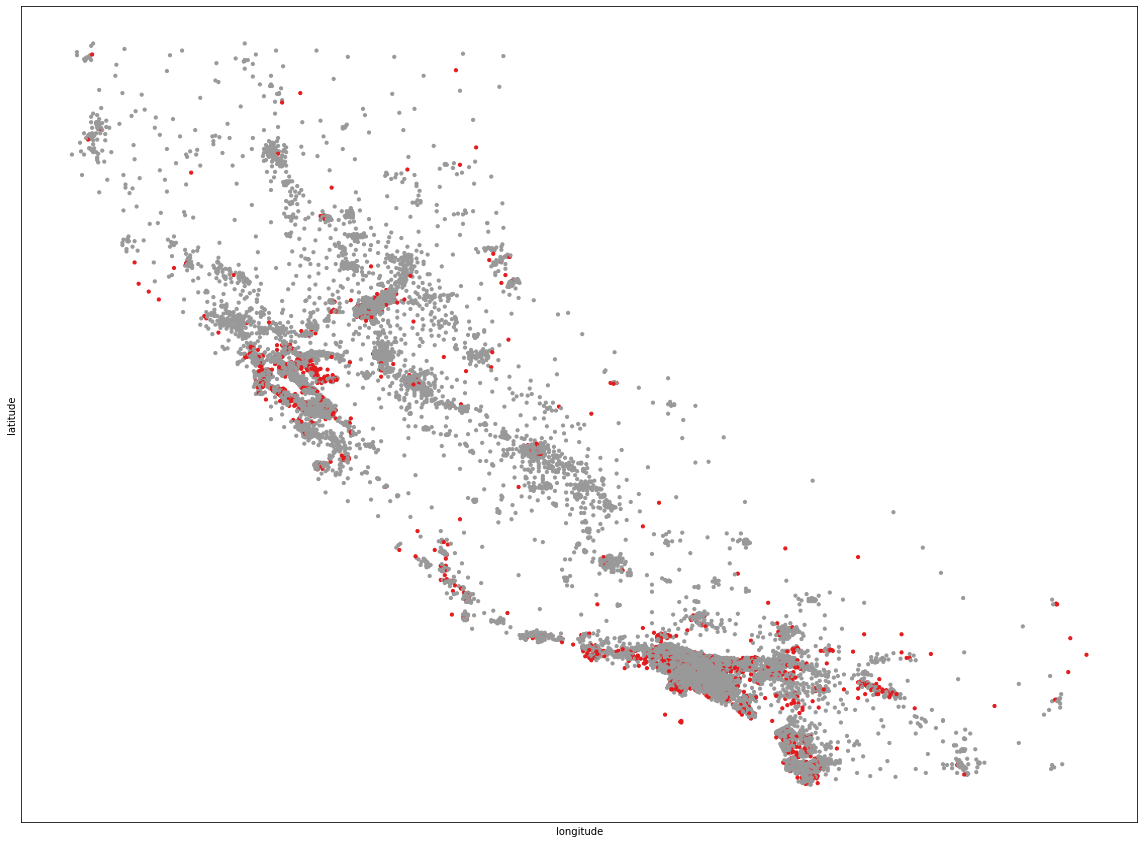

In [109]:
# cmap = cm.get_cmap('Set1')
plt.figure(figsize=(20, 15))
plt.scatter(x=data_prepared[:, 0],
            y=data_prepared[:, 1],
            c=clusters,
            cmap='Set1',
            s=10,
            )
plt.xticks([])
plt.yticks([])
plt.xlabel('longitude')
plt.ylabel('latitude')